ランダムフォレストを用いた結果の予測。ハイパーパラメーターの探索にはoptunaを用いた。

In [1]:
# 必要に応じで実行
# !pip install optuna

# ライブラリーのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import optuna

# データのインポート

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# データの分析

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Pclass（チケットのクラス）の分布

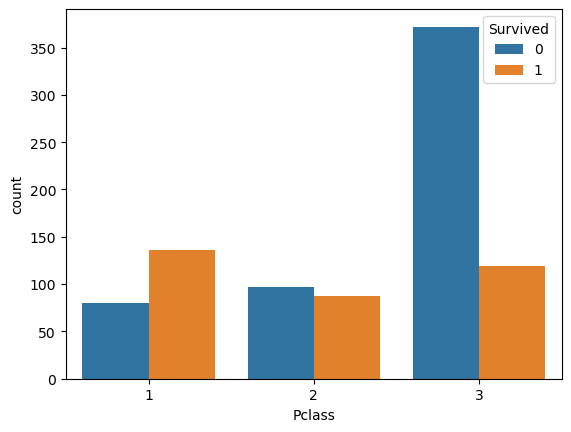

In [7]:
sns.countplot(x="Pclass", hue="Survived", data=train_data)
plt.show()

Sex（性別）の分布

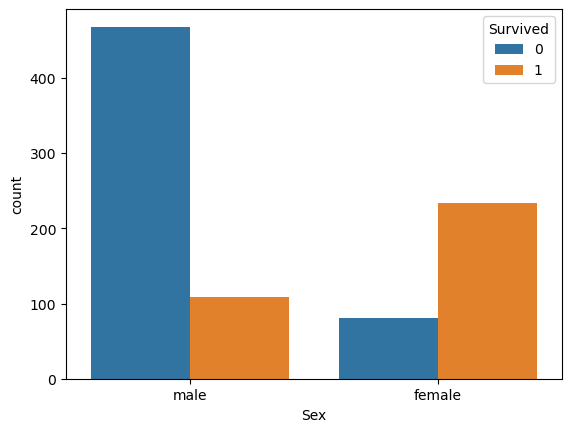

In [8]:
sns.countplot(x="Sex", hue="Survived", data=train_data)
plt.show()

Age（年齢）の分布

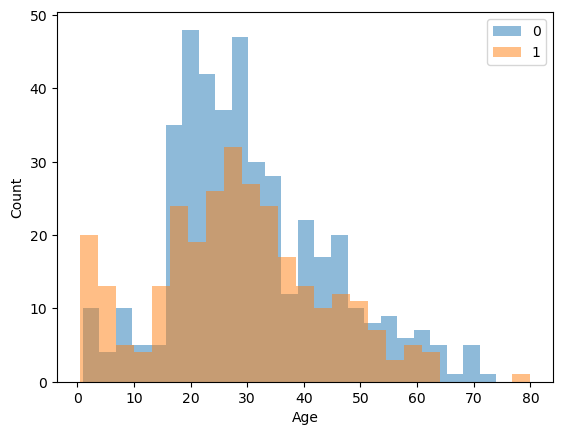

In [9]:
# 棒グラフの描画
plt.hist(train_data.loc[train_data["Survived"]==0, "Age"].dropna(),
         bins=25, alpha=0.5, label="0")  # 死亡
plt.hist(train_data.loc[train_data["Survived"]==1, "Age"].dropna(),
         bins=25, alpha=0.5, label="1")  # 生存

# 軸ラベル
plt.xlabel("Age")
plt.ylabel("Count")

plt.legend()
plt.show()

SibSp(兄弟、配偶者)の数の分布

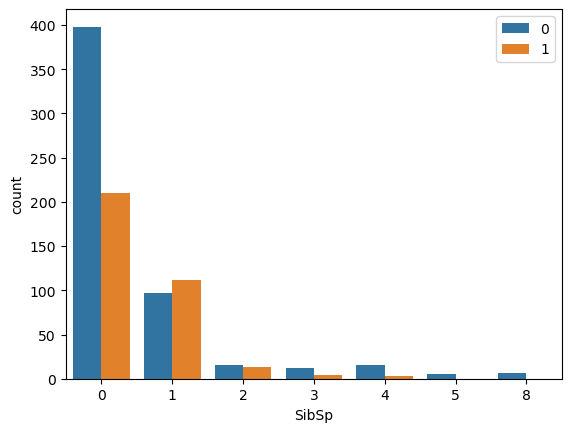

In [10]:
sns.countplot(x="SibSp", hue="Survived", data=train_data)
plt.legend()
plt.show()

Parch(親、子供の数)の分布

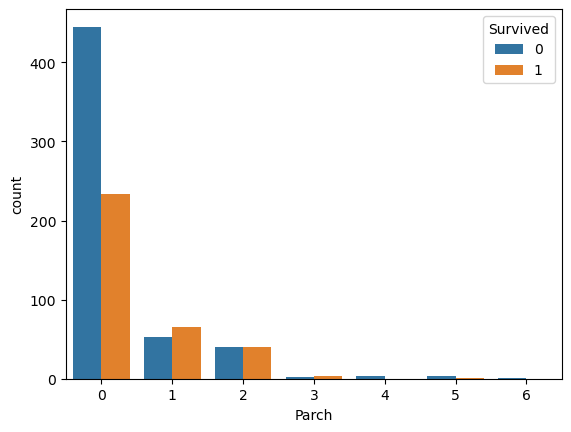

In [11]:
sns.countplot(x="Parch", hue="Survived", data=train_data)
plt.show()

Fare（料金）の分布

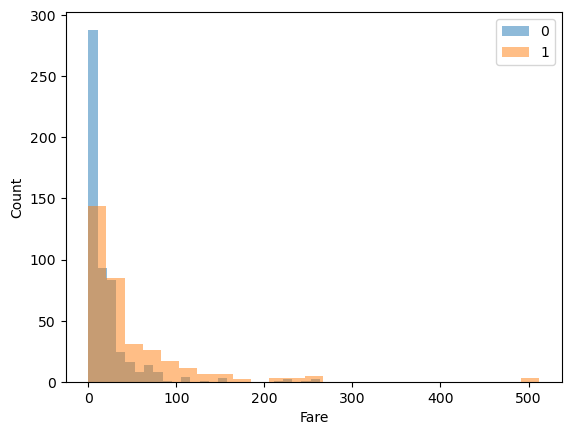

In [12]:
bins = 25  # 棒の数
alpha = 0.6  # 棒の透明度

plt.hist(train_data.loc[train_data["Survived"] == 0, "Fare"].dropna(),
         bins=25, alpha=0.5, label="0")  # 死亡
plt.hist(train_data.loc[train_data["Survived"] == 1, "Fare"].dropna(),
         bins=25, alpha=0.5, label="1")  # 生存

# 軸ラベル
plt.xlabel("Fare")
plt.ylabel("Count")

plt.legend()
plt.show()

Embarked（出港地）の分布

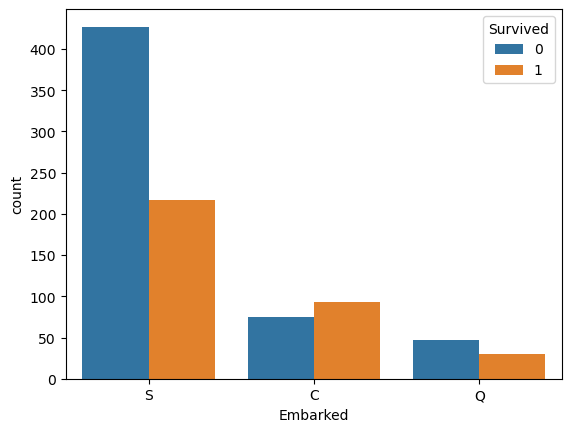

In [13]:
sns.countplot(x="Embarked", hue="Survived", data=train_data)
plt.show()

In [14]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# データの前処理

In [16]:
# 結果の提出時に使用
test_id = test_data["PassengerId"]

# データの統合
data = pd.concat([train_data, test_data], sort=False)

# 欠損値の補填
data['Age'].fillna(data['Age'].mean(),inplace=True)
data["Embarked"].fillna('S', inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

# カテゴリーデータの変換
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)

# 不要な特徴量の削除
data.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1, inplace=True)

# データの再分割
train_data = data[:len(train_data)]
test_data = data[len(train_data):]

x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, :1]
x_test = test_data.iloc[:, 1:]

In [17]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# 訓練用と検証用にデータを分割

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)

# モデル構築

In [19]:
# optunaの目的関数を設定する
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,1000)
    n_estimators =  trial.suggest_int('n_estimators', 1, 1000)

    model = RandomForestClassifier(max_depth = max_depth,
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    score = log_loss(y_valid, y_pred)  # 二値の交差エントロピー誤差
    return score

# optunaで最適値を見つける
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

[I 2022-12-14 11:46:50,520] A new study created in memory with name: no-name-ba37ffea-b576-48a0-9522-9aa448bfc816
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:46:51,691] Trial 0 finished with value: 6.701619267458282 and parameters: {'max_depth': 83, 'max_features': 'auto', 'max_leaf_nodes': 470, 'n_estimators': 931}. Best is trial 0 with value: 6.701619267458282.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:46:52,566] Trial 1 finished with value: 6.443864221237194 and parameters: {'max_depth': 50, 'max_features': 's

/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:00,865] Trial 16 finished with value: 6.443864221237194 and parameters: {'max_depth': 57, 'max_features': 'sqrt', 'max_leaf_nodes': 408, 'n_estimators': 866}. Best is trial 2 with value: 6.959374313679371.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:01,261] Trial 17 finished with value: 6.572743236133989 and parameters: {'max_depth': 91, 'max_features': 'auto', 'max_leaf_nodes': 861, 'n_estimators': 353}. Best is trial 2 with value: 6.959374313679371.
/var/folders/x

[I 2022-12-14 11:47:13,960] Trial 32 finished with value: 6.314988189912901 and parameters: {'max_depth': 87, 'max_features': 'sqrt', 'max_leaf_nodes': 449, 'n_estimators': 856}. Best is trial 2 with value: 6.959374313679371.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:14,832] Trial 33 finished with value: 6.443864221237194 and parameters: {'max_depth': 95, 'max_features': 'sqrt', 'max_leaf_nodes': 857, 'n_estimators': 723}. Best is trial 2 with value: 6.959374313679371.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 

/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:18,993] Trial 49 finished with value: 7.4748873896940475 and parameters: {'max_depth': 82, 'max_features': 'log2', 'max_leaf_nodes': 260, 'n_estimators': 68}. Best is trial 49 with value: 7.4748873896940475.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:19,060] Trial 50 finished with value: 6.5727372689889885 and parameters: {'max_depth': 45, 'max_features': 'log2', 'max_leaf_nodes': 225, 'n_estimators': 46}. Best is trial 49 with value: 7.4748873896940475.
/var/folde

/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:21,037] Trial 66 finished with value: 7.732627518052633 and parameters: {'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': 135, 'n_estimators': 8}. Best is trial 64 with value: 8.248113741914803.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:21,057] Trial 67 finished with value: 6.186103207871105 and parameters: {'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': 147, 'n_estimators': 10}. Best is trial 64 with value: 8.248113741914803.
/var/folders/xz

/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:22,236] Trial 83 finished with value: 7.732609616617627 and parameters: {'max_depth': 83, 'max_features': 'auto', 'max_leaf_nodes': 47, 'n_estimators': 2}. Best is trial 64 with value: 8.248113741914803.
/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/1529548576.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
[I 2022-12-14 11:47:22,247] Trial 84 finished with value: 10.567873355034584 and parameters: {'max_depth': 83, 'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 3}. Best is trial 84 with value: 10.567873355034584.
/var/folders/xz/7

[I 2022-12-14 11:47:23,773] Trial 99 finished with value: 5.928342194505016 and parameters: {'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': 55, 'n_estimators': 553}. Best is trial 84 with value: 10.567873355034584.


In [20]:
# ベストなハイパーパラメーターを表示
print(study.best_params)

{'max_depth': 83, 'max_features': 'auto', 'max_leaf_nodes': 3, 'n_estimators': 3}


# 最適なハイパーパラメータの組み合わせを用いてモデル再構築

In [21]:
# モデルの訓練
model = RandomForestClassifier(max_depth = study.best_params['max_depth'],
                               max_features = study.best_params['max_features'],
                               max_leaf_nodes = study.best_params['max_leaf_nodes'],
                               n_estimators = study.best_params['n_estimators']
                              )

# モデルの訓練

In [22]:
model.fit(x_train, y_train)

/var/folders/xz/7ldk_n956cq_7v7jfrn60rf00000gn/T/ipykernel_1391/940050797.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestClassifier(max_depth=83, max_leaf_nodes=3, n_estimators=3)

# 結果の確認と提出

In [23]:
y_pred = model.predict(x_test)

y_pred = pd.Series(y_pred, name='Survived')
y_pred.astype(int)
submission_data = pd.concat([test_id, y_pred.astype(int)], axis=1)

submission_data.to_csv('submission_titanic_randomforest_optuna.csv', index=False)

In [24]:
submission_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
